# **Mini GPT Implementation**

This notebook implements and experiments the Generative Pretrained Transformer (GPT) series (e.g., GPT-2, GPT-3). The model architecture is the foundational building block underlying the GPT family, and its design is inspired by a major breakthrough in deep learning, natural language processing and machine translation: the **self-attention mechanism** introduced in **“Attention Is All You Need”** by Vaswani et al.

The models were trained on Outliers Book by Malcolm Gladwell only for experimental purposes.

In [ ]:
!pip install --quiet --upgrade pypdf tiktoken==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.6/330.6 kB 34.5 MB/s eta 0:00:00


In [ ]:
# install all the required libraries, modules and packages for this project.
import os
import time
from google.colab import drive
from pypdf import PdfReader
import re
import matplotlib.pyplot as plt
import tiktoken
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [ ]:
import subprocess

# list of packages.
packages = ['pypdf', 'matplotlib', 'tiktoken', 'torch']

print("package versions:\n")

for package in packages:
    try:
        result = subprocess.run(
            ['pip', 'show', package],
            capture_output=True,
            text=True
        )

        # extract version from output.
        for line in result.stdout.split('\n'):
            if line.startswith('Version:'):
                version = line.split(':')[1].strip()
                print(f"{package}=={version}")
                break
    except Exception as e:
        print(f"{package}: error - {e}")

package versions:

pypdf==6.7.0
matplotlib==3.10.0
tiktoken==0.6.0
torch==2.9.0+cu128


### **Load the book data that will be used to train the model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path to pdf file directory in google drive.
pdf_path = "/content/drive/MyDrive/Datasets/Book/"

In [ ]:
def pdf_to_text(pdf_path, output_txt_path=None, save_to_file=True):
    """reads pdf and converts to text, optionally saving to .txt file."""

    # check if pdf exists.
    if not os.path.exists(pdf_path):
        print(f"error: '{pdf_path}' not found.")
        return None

    try:
        # open pdf in binary mode.
        with open(pdf_path, 'rb') as file:

            # create pdf reader.
            reader = PdfReader(file)
            num_pages = len(reader.pages)
            print(f"processing {num_pages} pages...")

            # extract all text.
            full_text = []
            for page_num in range(num_pages):
                page = reader.pages[page_num]
                text = page.extract_text()

                if text:
                    full_text.append(text)
                else:
                    print(f"warning: page {page_num + 1} had no extractable text.")

            # combine all pages.
            combined_text = "\n\n".join(full_text)

            # save to file if requested.
            if save_to_file:
                if output_txt_path is None:
                    output_txt_path = pdf_path.replace('.pdf', '.txt')

                with open(output_txt_path, 'w', encoding='utf-8') as txt_file:
                    txt_file.write(combined_text)

                print(f"saved to: {output_txt_path}")

            return combined_text

    except Exception as e:
        print(f"error reading pdf: {e}")
        return None

In [ ]:
def batch_pdf_to_text(folder_path, output_folder=None):
    """converts all pdfs in a folder to text files."""

    # check if folder exists.
    if not os.path.exists(folder_path):
        print(f"error: folder '{folder_path}' not found.")
        return

    # create output folder if needed.
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # get all pdf files.
    pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]

    if not pdf_files:
        print("no pdf files found in folder.")
        return

    print(f"found {len(pdf_files)} pdf files. converting...")

    combined_texts = []

    # process each pdf.
    for pdf_file in pdf_files:
        pdf_path = os.path.join(folder_path, pdf_file)

        if output_folder:
            output_path = os.path.join(output_folder, pdf_file.replace('.pdf', '.txt'))
        else:
            output_path = None

        print(f"\nprocessing: {pdf_file}")

        combined_texts.append(pdf_to_text(pdf_path, output_path))

    print("\nbatch conversion complete!")

    return combined_texts

In [ ]:
raw_text_contents = batch_pdf_to_text(pdf_path)

found 1 pdf files. converting...

processing: Outliers_Malcolm_Gladwell.pdf
processing 249 pages...
saved to: /content/drive/MyDrive/Datasets/Book/Outliers_Malcolm_Gladwell.txt

batch conversion complete!


In [ ]:
raw_text_content = raw_text_contents[0]

In [ ]:
print("Total number of character:", len(raw_text_content), "\n")
print(raw_text_content[:99])

Total number of character: 460987 

OUTLIERS
The Story of Success
MALCOLM GLADWELL
BACK BAY BOOKS
LITTLE, BROWN AND COMPANY
NEW YORK   


In [ ]:
def preprocess_text(raw_text, max_preview=30):
    """splits text on punctuation and whitespace, removes empty strings."""

    # split on common punctuation and whitespace.
    pattern = r'([,.:;?_!"()\'\[\]{}\/\\|—–-]+|\.\.\.|\s+)'

    tokens = re.split(pattern, raw_text)

    # remove whitespace and filter empty strings.
    preprocessed = [item.strip() for item in tokens if item.strip()]

    # preview first n tokens.
    if max_preview:
        print(f"first {max_preview} tokens:")
        print(preprocessed[:max_preview])
        print(f"\ntotal word level tokens: {len(preprocessed)}\n")

    return preprocessed

In [ ]:
preprocessed = preprocess_text(raw_text_content, max_preview=30)

# get the vocabulary size of the dataset.
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

first 30 tokens:
['OUTLIERS', 'The', 'Story', 'of', 'Success', 'MALCOLM', 'GLADWELL', 'BACK', 'BAY', 'BOOKS', 'LITTLE', ',', 'BROWN', 'AND', 'COMPANY', 'NEW', 'YORK', '•', 'BOSTON', '•', 'LONDON', 'Begin', 'Reading', 'Table', 'of', 'Contents', 'Reading', 'Group', 'Guide', 'Copyright']

total word level tokens: 92758

11324


In [ ]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer, token in enumerate(all_tokens)}

In [ ]:
class WordTokenizer:
    """tokenizes text into ids and decodes ids back to text. it focuses on word-level tokenization."""

    def __init__(self, vocab):
        """initializes tokenizer with vocabulary mappings."""

        self.tok_to_int = vocab
        self.int_to_tok = {integer: token for token, integer in vocab.items()}
        self.pattern = r'([,.:;?_!"()\'\[\]{}\/\\|—–-]+|\.\.\.|\s+)'

    def encode(self, text):
        """converts text to list of token ids."""

        # split on punctuation and whitespace.
        preprocessed = re.split(self.pattern, text)

        # remove empty strings and whitespace.
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        # replace unknown tokens with <|unk|>.
        preprocessed = [token if token in self.tok_to_int else "<|unk|>" for token in preprocessed]

        # convert tokens to ids.
        ids = [self.tok_to_int[tok] for tok in preprocessed]

        # return ids
        return ids


    def decode(self, ids):
        """converts list of token ids back to text."""

        # map ids to tokens.
        tokens = [self.int_to_tok[id] for id in ids]

        # join tokens with spaces.
        text = " ".join(tokens)

        # remove spaces before punctuation.
        text = re.sub(self.pattern, r'\1', text)

        # remove spaces before punctuation.
        text = re.sub(r'\s+([,.:;?_!"()\'\[\]{}\/\\|—–-])', r'\1', text)

        return text

In [ ]:
# initialize the wordtokenizer class.
tokenizer = WordTokenizer(vocab)

# sample text from (and outside) outliers book.
text1 = "Chris Langan's mother was from San Francisco and was estranged from her family."

# sample text with unknown words for testing.
text2 = "do you know about smartphone cryptocurrency?"


# combine texts with special separator token.
text = " <|endoftext|> ".join((text1, text2))

print(f"original text: {text}")

# convert text to token ids.
encoded_text = tokenizer.encode(text)
print(f"\nencoded text: {encoded_text}")

# convert token ids back to text.
decoded_text = tokenizer.decode(encoded_text)
print(f"\ndecoded text: {decoded_text}")

original text: Chris Langan's mother was from San Francisco and was estranged from her family. <|endoftext|> do you know about smartphone cryptocurrency?

encoded text: [915, 1905, 11325, 11325, 7500, 10581, 5993, 2676, 1342, 3561, 10581, 5524, 5993, 6370, 5700, 29, 11325, 11325, 11325, 11325, 11325, 5192, 10835, 6940, 3291, 11325, 11325, 430]

decoded text: Chris Langan <|unk|> <|unk|> mother was from San Francisco and was estranged from her family. <|unk|> <|unk|> <|unk|> <|unk|> <|unk|> do you know about <|unk|> <|unk|>?


### **Byte Pair Encoding (BPE) Tokenizer.**

The GPT Series uses a more sophisticated encoding preprocessing technique to convert human language (texts or words) into sub-word units for its training processes. It uses the Byte Pair Encoding (BPE) tokenizer. BPE tokenizer is fast, performant and compressed compared to other tokenization methods.

Its implementation is quite complex and time-consuming, so I used the tiktoken open-source library to bypass this process (the logic is almost akin to the WordTokenizer implemented above). Tiktoken is an invertible and lossless tokenization technique. it can work on arbitrary text - even text that is not present in the tokenizer's training data. it compresses the text, whereby making the token sequence shorter than the bytes corresponding to the original text.

It also attempts to let the model see common subwords. For instance, "ing" is a common subword in English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing" (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and again in different contexts, it helps in better contextual understanding of grammar and in generalization of models.

In [ ]:
# instantiate bpe tokenizer from tiktoken.
tokenizer_encoder = tiktoken.get_encoding("gpt2")

# convert text to token ids.
encoded_text = tokenizer_encoder.encode(text, allowed_special={"<|endoftext|>"})
print(f"\nbpe tokenizer's encoded text: {encoded_text}")

# convert token ids back to text.
decoded_text = tokenizer_encoder.decode(encoded_text)
print(f"\nbpe tokenizer's decoded text: {decoded_text}")

# display the gpt-2 bpe tovocabulary size.
print(f"\nthe vocabulary size of gpt-2 tokenizer is {tokenizer_encoder.n_vocab}")


bpe tokenizer's encoded text: [15645, 16332, 272, 338, 2802, 373, 422, 2986, 6033, 290, 373, 44585, 422, 607, 1641, 13, 220, 50256, 466, 345, 760, 546, 11745, 20210, 30]

bpe tokenizer's decoded text: Chris Langan's mother was from San Francisco and was estranged from her family. <|endoftext|> do you know about smartphone cryptocurrency?

the vocabulary size of gpt-2 tokenizer is 50257


In [ ]:
class BPETokenizer:
    """tokenizes text using byte pair encoding (bpe). uses tiktoken's gpt-2 tokenizer."""

    def __init__(self, model_name="gpt2"):
        """initializes bpe tokenizer with specified model."""

        # load tiktoken encoder for the specified model.
        self.tokenizer = tiktoken.get_encoding(model_name)

        # obtain and store the tokenizer's vocab size.
        self.vocab_size = self.tokenizer.n_vocab

    def encode(self, text, allowed_special=None):
        """converts text to list of token ids."""

        # set default allowed special tokens.
        if allowed_special is None:
            allowed_special = {"<|endoftext|>"}

        # convert text to token ids.
        ids = self.tokenizer.encode(text, allowed_special=allowed_special)

        return ids

    def decode(self, ids):
        """converts list of token ids back to text."""

        # convert token ids back to text.
        text = self.tokenizer.decode(ids)

        return text

    def get_vocab_size(self):
        """returns the vocabulary size of the tokenizer."""

        return self.vocab_size

In [ ]:
# initialize tokenizer.
tokenizer = BPETokenizer()

# get total character count.
total_characters = len(raw_text_content)

# get total token count after encoding.
total_tokens = len(tokenizer.encode(raw_text_content))

print("The total characters:", total_characters)
print("The total tokens:", total_tokens)

The total characters: 460987
The total tokens: 115003


We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

In [ ]:
gpt_config_124M = {
    "vocab_size": 50257,  # the model's vocabulary size.
    "embed_dim": 768,  # the embedding function.
    "num_heads": 12, # the number of attention heads.
    "num_layers": 12, # the number of transformer layers.
    "context_length": 256, # the model's context length. this is the shortened context length (original context length is 1024).
    "drop_rate": 0.2, # the probability of drop out rate.
    "qkv_bias": False, # the query-key-value bias.
}

In [ ]:
class GPTTextDataset(Dataset):
    """pytorch custom dataset for tokenized text data."""

    def __init__(self, txt, tokenizer, context_length=256, stride=128):
        """initializes dataset with text files and tokenizer."""

        self.tokenizer = tokenizer
        self.context_length = context_length
        self.stride = stride

        # tokenize all text and create chunks.
        self.input_ids = []
        self.target_ids = []

        # tokenize the entire text (document).
        token_ids = self.tokenizer.encode(txt)

        # create a sliding window to chunk the text (document) into overlapping sequences of context length.
        for i in range(0, len(token_ids) - self.context_length, self.stride):

            # input is current chunk.
            input_chunk = token_ids[i:i + self.context_length]

            # target is shifted by one position.
            target_chunk = token_ids[i + 1:i + self.context_length + 1]

            # ensure both chunks are same length.
            if len(input_chunk) == self.context_length and len(target_chunk) == self.context_length:
                self.input_ids.append(input_chunk)
                self.target_ids.append(target_chunk)

    def __len__(self):
        """returns the number of samples in dataset."""

        return len(self.input_ids)

    def __getitem__(self, idx):
        """returns input and target tensors for given index."""

        # convert to tensors with long data type.
        input_tensor = torch.tensor(self.input_ids[idx], dtype=torch.long)
        target_tensor = torch.tensor(self.target_ids[idx], dtype=torch.long)

        return input_tensor, target_tensor



def create_dataloader(dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=0):
    """creates pytorch dataloader from the custom dataset."""

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=False,
    )

    return dataloader

In [ ]:
text_data = GPTTextDataset(raw_text_content, tokenizer, gpt_config_124M["context_length"], stride=128)

In [ ]:
# set train/validation split ratio.
train_ratio = 0.90
dataset_len = len(text_data)

# calculate split sizes.
train_len = int(train_ratio * dataset_len)
val_len = dataset_len - train_len

# set seed for reproducible split.
torch.manual_seed(66)

# split dataset into train and validation sets.
train_data, val_data = random_split(
    text_data,
    [train_len, val_len]
)

# set seed for reproducible data loading.
torch.manual_seed(66)

# create training data loader.
train_loader = create_dataloader(
    train_data,
    batch_size=8,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

# create validation data loader.
val_loader = create_dataloader(
    val_data,
    batch_size=8,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

In [ ]:
# sanity check for sufficient training tokens.
if total_tokens * train_ratio < gpt_config_124M["context_length"]:
    print("not enough tokens for the training loader. "
          "try to lower the `gpt_config_124m['context_length']` or "
          "increase the `training_ratio`")

# sanity check for sufficient validation tokens.
if total_tokens * (1 - train_ratio) < gpt_config_124M["context_length"]:
    print("not enough tokens for the validation loader. "
          "try to lower the `gpt_config_124m['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
# count total tokens in training set.
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

# count total tokens in validation set.
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

# display token counts.
print("training tokens:", train_tokens)
print("validation tokens:", val_tokens)
print("all tokens:", train_tokens + val_tokens)

training tokens: 204800
validation tokens: 22528
all tokens: 227328


### Guassian Error Linear Unit (GELU)

In [ ]:
class GELU(nn.Module):
    """gaussian error linear unit (gelu) activation function. mathematical implementation of gelu."""

    def __init__(self):
        """initializes gelu activation."""

        super().__init__()

    def forward(self, x):
        """applies gelu activation to input tensor."""

        # compute gelu activation using tanh approximation.
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                (x + 0.044715 * torch.pow(x, 3))
            )
        )




### Layer Normalization

In [ ]:
class LayerNorm(nn.Module):
    """layer normalization for stabilizing neural network training."""

    def __init__(self, embed_dim):
        """initializes layer normalization with learnable parameters."""

        super().__init__()

        # small constant to prevent division by zero.
        self.eps = 1e-5

        # learnable scale parameter.
        self.scale = nn.Parameter(torch.ones(embed_dim))

        # learnable shift parameter.
        self.shift = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x):
        """applies layer normalization to input tensor."""

        # calculate mean across last dimension.
        mean = x.mean(dim=-1, keepdim=True)

        # calculate variance across last dimension.
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        # normalize input.
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        # apply scale and shift.
        return self.scale * norm_x + self.shift

### Feed Forward Sub-Layer

In [ ]:
class FeedForward(nn.Module):
    """position-wise feed-forward network in transformer. the second sub-layer in each transformer block."""

    def __init__(self, config):
        """initializes feed-forward network with two linear layers."""

        super().__init__()

        # save model configuration for future extraction.
        self.config = config

        # two-layer mlp with gelu activation. it expands to 4x embed_dim then projects back.
        self.layers = nn.Sequential(
            nn.Linear(self.config["embed_dim"], 4 * self.config["embed_dim"]),
            nn.GELU(),
            nn.Linear(4 * self.config["embed_dim"], self.config["embed_dim"]),
        )

    def forward(self, x):
        """applies feed-forward transformation to input."""

        return self.layers(x)

### Self Attention Mechanism

In [ ]:
class SelfAttention(nn.Module):
    """self-attention mechanism for processing sequences."""

    def __init__(self, d_in, d_out, qkv_bias=False):
        """initializes self-attention with query, key, and value projections."""

        super().__init__()

        # query projection layer.
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)

        # key projection layer.
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)

        # value projection layer.
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)


    def forward(self, x):
        """applies self-attention to input sequence."""

        # compute queries, keys, and values.
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # get key dimension for scaling.
        d_k = keys.shape[-1]
        scaling_factor = d_k**0.5

        # compute attention scores.
        attn_scores = queries @ keys.transpose(1, 2)

        # apply scaled softmax to get attention weights.
        attn_weights = torch.softmax(attn_scores / scaling_factor, dim=-1)

        # compute weighted sum of values.
        context_vector = attn_weights @ values

        return context_vector

### Causal Attention

In [ ]:
class CausalAttention(nn.Module):
    """causal self-attention with masking to prevent attending to future tokens (preventing the model from peeking or cheating by having context on future tokens)."""

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        """initializes causal attention with query, key, value projections and mask."""

        super().__init__()

        # output dimension.
        self.d_out = d_out

        # query projection layer.
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)

        # key projection layer.
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)

        # value projection layer.
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # dropout layer.
        self.dropout = nn.Dropout(dropout)

        # causal mask to prevent attending to future positions.
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        """applies causal self-attention to input sequence."""

        # get batch size, sequence length, and input dimension.
        batch, num_tokens, d_in = x.shape

        # compute queries, keys, and values.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # get key dimension for scaling.
        d_k = keys.shape[-1]
        scaling_factor = d_k**0.5

        # compute attention scores.
        attn_scores = queries @ keys.transpose(1, 2)

        # apply causal mask to prevent attending to future tokens.
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        # apply scaled softmax to get attention weights.
        attn_weights = torch.softmax(attn_scores / scaling_factor, dim=-1)

        # apply dropout to attention weights.
        attn_weights = self.dropout(attn_weights)

        # compute weighted sum of values.
        context_vec = attn_weights @ values

        return context_vec

### Multi-Head Attention (MHA)

In [ ]:
class MultiHeadWrapper(nn.Module):
    """multi-head wrapper mechanism with multiple parallel attention heads."""

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        """initializes multi-head attention with multiple causal attention heads."""

        super().__init__()

        # list of attention heads running in parallel.
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for i in range(num_heads)]
        )

    def forward(self, x):
        """applies all attention heads and concatenates their outputs."""

        # run each head and concatenate results along feature dimension.
        return torch.cat([head(x) for head in self.heads], dim=-1)

Even though the MultiHeadAttention class looks more complicated or tangled than the MultiHeadAttentionWrapper due to the additional reshaping and transposition of tensors, it is more efficient and performant.

The reason is that we only need one matrix multiplication to compute the keys, for instance, keys = self.W_key(x) (the same is true for the queries and values). Unlike, the MultiHeadAttentionWrapper, where we needed to repeat this matrix multiplication, which is computationally (and time-consuming) one of the most expensive steps, for each attention head.

In [ ]:
class MultiHeadAttention(nn.Module):
    """multi-head attention mechanism with multiple parallel attention heads."""

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        """initializes multi-head attention with projections and causal mask."""

        super().__init__()

        # ensure output dimension is divisible by number of heads.
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        # store dimensions.
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # query projection layer.
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)

        # key projection layer.
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)

        # value projection layer.
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # output projection to combine heads.
        self.out_proj = nn.Linear(d_out, d_out)

        # dropout layer.
        self.dropout = nn.Dropout(dropout)

        # causal mask to prevent attending to future positions (in order to avoid cheating).
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )


    def forward(self, x):
        """applies multi-head attention to input sequence."""

        # get batch size, sequence length, and input dimension.
        b, num_tokens, d_in = x.shape

        # compute queries, keys, and values.
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # split into multiple heads by reshaping.
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # rearrange to (batch, num_heads, seq_len, head_dim).
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # compute attention scores.
        attn_scores = queries @ keys.transpose(2, 3)

        # apply causal mask to prevent attending to future tokens.
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # get key dimension for scaling.
        d_k = keys.shape[-1]
        scaling_factor = d_k**0.5

        # apply scaled softmax to get attention weights.
        attn_weights = torch.softmax(attn_scores / scaling_factor, dim=-1)

        # apply dropout to attention weights.
        attn_weights = self.dropout(attn_weights)

        # compute weighted sum of values.
        context_vec = attn_weights @ values

        # rearrange back to (batch, seq_len, num_heads, head_dim).
        context_vec = context_vec.transpose(1, 2)

        # combine all heads by concatenating.
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # apply output projection.
        context_vec = self.out_proj(context_vec)

        return context_vec

### The Transformer Architecture

In [ ]:
class TransformerDecoderBlock(nn.Module):
    """transformer decoder block with multi-head attention and feed-forward layers."""

    def __init__(self, config):
        """initializes transformer block with attention and feed-forward components."""

        super().__init__()

        # multi-head attention layer.
        self.multi_att = MultiHeadAttention(
            d_in=config["embed_dim"],
            d_out=config["embed_dim"],
            context_length=config["context_length"],
            num_heads=config["num_heads"],
            dropout=config["drop_rate"],
            qkv_bias=config["qkv_bias"]
        )

        # layer normalization layers.
        self.norm1 = nn.LayerNorm(config["embed_dim"])
        self.norm2 = nn.LayerNorm(config["embed_dim"])

        # dropout for residual connections.
        self.drop_shortcut = nn.Dropout(config["drop_rate"])

        # feed-forward network.
        self.feed_for = FeedForward(config)

    def forward(self, x):
        """applies transformer block with residual connections."""

        ## -------  shortcut connection for multi-head attention sub-layer.  -------

        # store the original input.
        shortcut = x

        # apply layer normalization before the multi-head attention sub-layer.
        x = self.norm1(x)

        # apply the output of the layer normalization to the multi-head attention sub-layer.
        x = self.multi_att(x)

        # apply drop out.
        x = self.drop_shortcut(x)

        # add the original input back.
        x = x + shortcut

        ## ------  shortcut connection for feed forward sub-layer.  ------

        # store the original input.
        shortcut = x

        # apply layer normalization before the feed forward sub-layer.
        x = self.norm2(x)

        # apply the output of the layer normalization to the feed forward sub-layer.
        x = self.feed_for(x)

        # apply drop out.
        x = self.drop_shortcut(x)

        # add the original input back.
        x = x + shortcut

        return x

### GPT Model

In [ ]:
class GPTModel(nn.Module):
    """gpt model with transformer decoder blocks."""

    def __init__(self, config):
        """initializes gpt model with embeddings and transformer layers."""

        super().__init__()

        # token embedding layer.
        self.tok_emb = nn.Embedding(config["vocab_size"], config["embed_dim"])

        # positional embedding layer.
        self.pos_emb = nn.Embedding(config["context_length"], config["embed_dim"])

        # dropout for embeddings.
        self.drop_emb = nn.Dropout(config["drop_rate"])

        # stack of transformer decoder blocks.
        self.trf_blocks = nn.Sequential(
            *[TransformerDecoderBlock(config) for i in range(config["num_layers"])]
        )

        # final layer normalization.
        self.final_norm = nn.LayerNorm(config["embed_dim"])

        # output projection to vocabulary.
        self.out_head = nn.Linear(config["embed_dim"], config["vocab_size"], bias=False)

    def forward(self, in_idx):
        """forward pass through the gpt model."""

        # get batch size and sequence length.
        batch_size, seq_len = in_idx.shape

        # get token embeddings.
        tok_embeds = self.tok_emb(in_idx)

        # get positional embeddings.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        # combine token and positional embeddings.
        x = tok_embeds + pos_embeds

        # apply dropout to embeddings.
        x = self.drop_emb(x)

        # pass through transformer blocks.
        x = self.trf_blocks(x)

        # apply final normalization.
        x = self.final_norm(x)

        # project to vocabulary size.
        logits = self.out_head(x)

        return logits

In [ ]:
def calculate_loss_batch(input_batch, target_batch, model, device):
    """calculates loss for a single batch."""

    # move batch to device.
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    # get model predictions.
    logits = model(input_batch)

    # calculate cross-entropy loss.
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())

    return loss


def calculate_loss_loader(data_loader, model, device, num_batches=None):
    """calculates average loss across multiple batches from data loader."""

    total_loss = 0.0

    # handle empty data loader.
    if len(data_loader) == 0:
        return float("nan")

    # determine number of batches to process.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # limit to available batches.
        num_batches = min(num_batches, len(data_loader))

    # iterate through batches and accumulate loss.
    for i, (input_batch, target_batch) in enumerate(data_loader):

        if i < num_batches:
            # calculate loss for current batch.
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            if i == 0:
                break
        else:
            break

    # return average loss.
    return total_loss / num_batches

In [ ]:
# initialize gpt model.
model = GPTModel(gpt_config_124M)

# set device to gpu if available, otherwise cpu.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device.")

# move model to device.
model.to(device)

# set seed for reproducibility.
torch.manual_seed(66)

# calculate initial losses without gradient tracking (no model training is happening yet).
with torch.no_grad():

    # calculate training loss.
    train_loss = calculate_loss_loader(train_loader, model, device)

    # calculate validation loss.
    val_loss = calculate_loss_loader(val_loader, model, device)

# display initial losses.
print("training loss:", train_loss)
print("validation loss:", val_loss)

using cuda device.
training loss: 0.109576416015625
validation loss: 0.9976380088112571


In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """evaluates model on training and validation sets."""

    # set model to evaluation mode.
    model.eval()

    # calculate losses without gradient tracking.
    with torch.no_grad():

        # calculate training loss.
        train_loss = calculate_loss_loader(train_loader, model, device, num_batches=eval_iter)

        # calculate validation loss.
        val_loss = calculate_loss_loader(val_loader, model, device, num_batches=eval_iter)

    # set model back to training mode.
    model.train()

    return train_loss, val_loss

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """generates text by predicting tokens one at a time."""

    # set model to evaluation mode.
    model.eval()

    # generate tokens one by one.
    for _ in range(max_new_tokens):

        # crop context if it exceeds maximum context size.
        idx_cond = idx[:, -context_size:]

        # get model predictions without gradient tracking.
        with torch.no_grad():
            logits = model(idx_cond)

        # focus only on last time step.
        logits = logits[:, -1, :]

        # get token with highest probability (greedy decoding).
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # append sampled token to running sequence.
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [ ]:
def text_to_token_ids(text, tokenizer):
    """converts text to token ids with batch dimension."""

    # encode text to token ids.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})

    # convert to tensor and add batch dimension.
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    """converts token ids back to text."""

    # remove batch dimension.
    flat = token_ids.squeeze(0)

    # decode token ids to text.
    return tokenizer.decode(flat.tolist())


# set starting prompt for text generation.
starting_prompt = "who's an outlier?"

# convert text to token ids and move to device.
input_ids = text_to_token_ids(starting_prompt, tokenizer).to(device)

# generate text from prompt.
token_ids = generate_text_simple(
    model=model,
    idx=input_ids,
    max_new_tokens=10,
    context_size=gpt_config_124M["context_length"]
)

# display generated text.
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 who's an outlier? Cooking Trevor Code NeptuneNintendo Rodney McN chefs hack temporary


In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):

    model.eval()

    context_size = model.pos_emb.weight.shape[0]

    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)

    decoded_text = token_ids_to_text(token_ids, tokenizer)

    print(decoded_text.replace("\n", " "))

    model.train()

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, starting_prompt, tokenizer):

    # initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []

    tokens_seen, global_step = 0, -1

    # main training loop
    for epoch in range(num_epochs):

        # set model to training mode.
        model.train()


        for input_batch, target_batch in train_loader:

            # reset loss gradients from previous batch iteration.
            optimizer.zero_grad()

            loss = calculate_loss_batch(input_batch, target_batch, model, device)

            # calculate loss gradients.
            loss.backward()

            # update model weights using loss gradients.
            optimizer.step()

            # returns the total number of elements (or tokens) in the input_batch.
            tokens_seen += input_batch.numel()
            global_step += 1

            # optional evaluation step.
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # print a sample text after each epoch.
        generate_and_print_sample(model, tokenizer, device, starting_prompt)

    return train_losses, val_losses, track_tokens_seen

In [ ]:
# start timer for training duration.
start_time = time.time()

# set seed for reproducibility.
torch.manual_seed(66)

# initialize gpt model.
model = GPTModel(gpt_config_124M)

# move model to device.
model.to(device)

# set learning rate.
learning_rate = 0.0004

# set weight decay for regularization.
weight_decay = 0.1

# initialize adamw optimizer.
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# set number of training epochs.
num_epochs = 20

# train model and track losses.
train_losses, val_losses, tokens_seen = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    starting_prompt="explain who an outlier is?",
    tokenizer=tokenizer
)

# calculate and display training duration.
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"training completed in {execution_time_minutes:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 1.938, Val loss 1.931
Epoch 1 (Step 000005): Train loss 1.631, Val loss 1.654
Epoch 1 (Step 000010): Train loss 1.489, Val loss 1.502
Epoch 1 (Step 000015): Train loss 1.417, Val loss 1.422
Epoch 1 (Step 000020): Train loss 1.340, Val loss 1.431
Epoch 1 (Step 000025): Train loss 1.337, Val loss 1.354
Epoch 1 (Step 000030): Train loss 1.336, Val loss 1.342
Epoch 1 (Step 000035): Train loss 1.312, Val loss 1.351
Epoch 1 (Step 000040): Train loss 1.367, Val loss 1.321
Epoch 1 (Step 000045): Train loss 1.308, Val loss 1.327
Epoch 1 (Step 000050): Train loss 1.302, Val loss 1.319
Epoch 1 (Step 000055): Train loss 1.301, Val loss 1.328
Epoch 1 (Step 000060): Train loss 1.220, Val loss 1.334
Epoch 1 (Step 000065): Train loss 1.303, Val loss 1.219
Epoch 1 (Step 000070): Train loss 1.266, Val loss 1.236
Epoch 1 (Step 000075): Train loss 1.242, Val loss 1.266
Epoch 1 (Step 000080): Train loss 1.213, Val loss 1.278
Epoch 1 (Step 000085): Train loss 1.194, Val los

### **Save the trained model**

In [ ]:
# set number of epochs.
epochs = 20

# create models directory if it doesn't exist.
os.makedirs("models", exist_ok=True)

def save_model(model, filepath):
    """saves final trained model to disk."""

    # create directory if it doesn't exist.
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    # save only model state dict.
    torch.save(model.state_dict(), filepath)
    print(f"trained model saved at: {filepath}")


# define the path to save the model.
model_path = f"/content/drive/MyDrive/models/gpt2_final_epoch_{epochs}.pt"

# save final model (for inference only).
save_model(model, model_path)

trained model saved at: /content/drive/MyDrive/models/gpt2_final_epoch_20.pt


**Save the checkpoint of the trained model**

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    """saves model checkpoint to disk."""

    # create checkpoint directory if it doesn't exist.
    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    # save checkpoint.
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }

    torch.save(checkpoint, filepath)
    print(f"checkpoint saved: {filepath}")


# set number of epochs.
epochs = 20

# save final checkpoint.
checkpoint_path = f"/content/drive/MyDrive/checkpoint/checkpoint_epoch_{epochs}.pt"

# save model checkpoint to disk.
save_checkpoint(model, optimizer, epochs, train_losses[-1], checkpoint_path)

checkpoint saved: /content/drive/MyDrive/checkpoint/checkpoint_epoch_20.pt


### **Load the trained Model**

In [ ]:
def load_checkpoint(model, optimizer, filepath):
    """loads model checkpoint from disk."""

    # check if checkpoint exists.
    if not os.path.exists(filepath):
        print(f"checkpoint not found: {filepath}")
        return None

    # load checkpoint.
    checkpoint = torch.load(filepath)

    # load model and optimizer states.
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # extract the epoch and loss value.
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"checkpoint loaded: {filepath}")
    print(f"resumed from epoch {epoch} with loss {loss:.4f}")

    return epoch, loss


# initialize model and optimizer first.
model = GPTModel(gpt_config_124M)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)

# load checkpoint.
checkpoint_path = f"/content/drive/MyDrive/checkpoint/checkpoint_epoch_{epochs}.pt"
epoch, loss = load_checkpoint(model, optimizer, checkpoint_path)

checkpoint loaded: /content/drive/MyDrive/checkpoint/checkpoint_epoch_20.pt
resumed from epoch 20 with loss 0.0020


In [ ]:
def load_model(model, filepath, device='cpu'):
    """loads trained model from disk."""

    # check if model file exists.
    if not os.path.exists(filepath):
        print(f"model not found: {filepath}")
        return None

    # load model state dict.
    model.load_state_dict(torch.load(filepath, map_location=device))

    print(f"model loaded from: {filepath}")

    return model

In [ ]:
# load the trained model (which should be used for inference only).
model_path = f"/content/drive/MyDrive/models/gpt2_final_epoch_{epochs}.pt"

model = load_model(model, model_path)

model loaded from: /content/drive/MyDrive/models/gpt2_final_epoch_20.pt


### Use the Model for Word Predictions

In [ ]:
device="cpu"

In [ ]:
def text_to_token_ids(text, tokenizer):
    """converts text to token ids with batch dimension."""

    # encode text to token ids.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})

    # convert to tensor and add batch dimension.
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    """converts token ids back to text."""

    # remove batch dimension.
    flat = token_ids.squeeze(0)

    # decode token ids to text.
    return tokenizer.decode(flat.tolist())


# set starting prompt for text generation.
prompt = "lawyer is"

# convert text to token ids and move to device.
input_ids = text_to_token_ids(prompt, tokenizer).to(device)

# generate text from prompt.
token_ids = generate_text_simple(
    model=model,
    idx=input_ids,
    max_new_tokens=100,
    context_size=gpt_config_124M["context_length"]
)

# display generated text.
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 lawyer is a ‘dignified road tostarvation.’ ” Regardless of the number of years they had spent in practice, theirincome was “strikingly less” than that of their Christian colleagues. Maurice Janklowwas born in 1902. When the Depression started, he was newly married and had justbought his big car, moved to Queens, and made his great gamble on the writing-paperbusiness. His timing could not have been worse.

“


The model has been trained from scratch effectively to understand and capture the intricacies behind languages. Currently, it is somewhat excellent at predicting the next words (tokens). For improved performance in question-answering, it is advisable and recommendable to perform instruction fine-tuning on a massive instruction dataset.

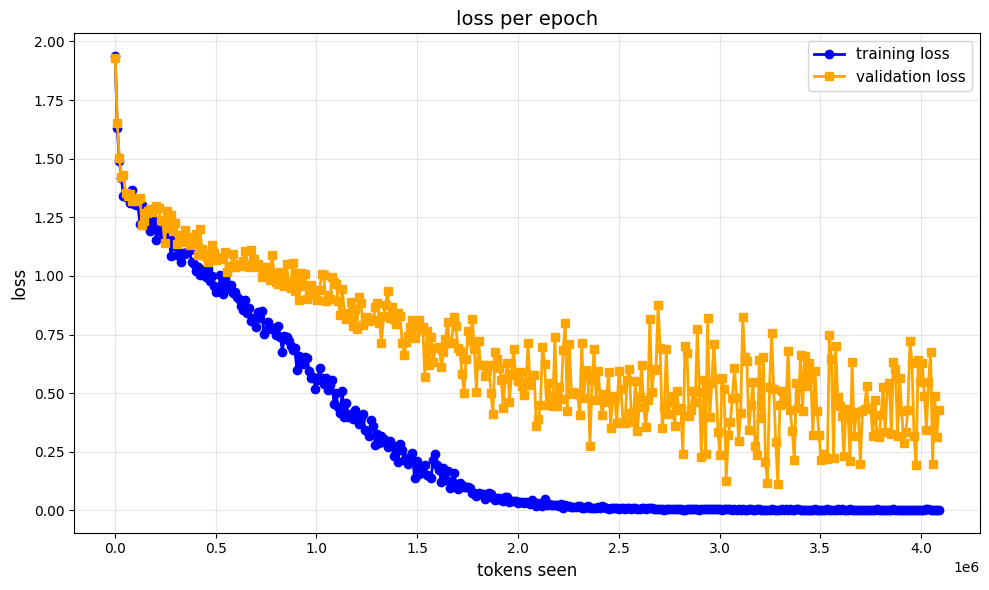

In [ ]:
def plot_metric(train_losses, val_losses, tokens_seen, title="loss per epoch", save_path=None):
    """plots training and validation losses over tokens seen."""

    # create figure and axis.
    fig, ax = plt.subplots(figsize=(10, 6))

    # plot training loss.
    ax.plot(tokens_seen, train_losses, label="training loss", color="blue", linewidth=2, marker="o")

    # plot validation loss.
    ax.plot(tokens_seen, val_losses, label="validation loss", color="orange", linewidth=2, marker="s")

    # add labels and title.
    ax.set_xlabel("tokens seen", fontsize=12)
    ax.set_ylabel("loss", fontsize=12)
    ax.set_title(title, fontsize=14)

    # add legend.
    ax.legend(fontsize=11)

    # add grid for readability.
    ax.grid(alpha=0.3)

    # adjust layout.
    plt.tight_layout()

    # save figure if path provided.
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"plot saved to: {save_path}")

    # display plot.
    plt.show()


plot_metric(train_losses, val_losses, tokens_seen)

In [ ]:
def generate_text(model, tokenizer, prompt, max_tokens=100, temperature=1.0, device="cpu"):
    """generates text from a prompt using the trained model."""

    model.eval()

    # encode prompt.
    input_ids = tokenizer.encode(prompt)
    input_tensor = torch.tensor([input_ids]).to(device)

    generated_ids = input_ids.copy()

    with torch.no_grad():
        for _ in range(max_tokens):

            # get model predictions.
            outputs = model(input_tensor)

            # get last token logits.
            logits = outputs[0, -1, :] / temperature

            # sample next token.
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()

            # append to generated sequence.
            generated_ids.append(next_token)

            # update input tensor.
            input_tensor = torch.tensor([generated_ids]).to(device)


    # decode generated ids.
    generated_text = tokenizer.decode(generated_ids)

    return generated_text


checkpoint = ''
prompt = "a proverb related to the japanese says: no one who can rise before dawn three hundred"

max_tokens = 45

temperature = 1.0

# initialize model.
model = GPTModel(gpt_config_124M).to(device)

# initialize optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004)

# load checkpoint.
checkpoint_path = f"/content/drive/MyDrive/checkpoint/checkpoint_epoch_{epochs}.pt"

# load checkpoint.
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"loaded checkpoint from: {checkpoint_path}\n")
print(f"prompt: {prompt}\n")

# generate text using the trained model.
generated_text = generate_text(model, tokenizer, prompt, max_tokens=max_tokens,
                               temperature=temperature, device=device)

# print generated text with newlines replaced by spaces.
print(f"generated text:\n{generated_text.replace("\n", " ")}")

loaded checkpoint from: /content/drive/MyDrive/checkpoint/checkpoint_epoch_20.pt

prompt: a proverb related to the japanese says: no one who can rise before dawn three hundred

generated text:
a proverb related to the japanese says: no one who can rise before dawn three hundred safe himself to help pay his sentences. And without any financial aid either,’t working from—and prayed—New Scientist Berkeley. He has writtenonder how he once. interests study gets interesting,
